<a href="https://colab.research.google.com/github/heitorabqg/datascientist/blob/master/PSI5892_HA_lms_eco_20251013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Para abrir o notebook no Google Colab, altere o domínio `github.com` para `githubtocolab.com`

<div class="alert alert-block alert-danger">
Para praticar programação, é importante que você erre, leia as mensagens de erro e tente corrigí-los.
    
Dessa forma, no Google Colab, é importante que você DESATIVE OS RECURSOS DE AUTOCOMPLETAR:

- Menu Ferramentas -> Configurações
- Na janela que é aberta:
  - Seção Editor -> Desativar "Mostrar sugestões de preenchimento de código com base no contexto"
  - Seção Assistência de IA -> Desabilitar itens

Na versão em inglês:

- Menu Tools -> Settings
- Na janela que é aberta:
  - Seção Editor -> Desativar "Show context-powered code completions"
  - Seção AI Assistance -> Desabilitar itens
</div>

# PSI5892 - Aula de Exercícios

# Cancelamento de eco acústico com o algoritmo NLMS


Considere o seguinte diagrama de blocos, onde:

- $x(n)$ representa amostras de um sinal de voz;
- $v(n)$ é ruído branco gaussiano de média nula e variância $\sigma_v^2$;
- $d(n)$  é a soma do eco (obtido a partir da filtragem do sinal de voz pela resposta ao pulso unitário do ambiente) com o ruído $v(n)$, ou seja: $d(n)=x(n)\ast h(n)+v(n)$ sendo $h(n)$ a resposta ao pulso unitário do ambiente;
- $e(n)$ é o erro definido como $e(n)=d(n)-y(n)$.

<img src="https://github.com/psi5892/exercicios_aula_publico/blob/main/ex_aula_lms_eco/fig_ex_eco_diagrama_blocos.png?raw=1" style="margin:auto"/>

Para que o cancelador de eco acústico tenha um desempenho satisfatório é necessário que o número de
coeficientes do filtro adaptativo satisfaça a seguinte inequação:
$$
MT_a>\tau
$$
sendo $M$ o número de coeficientes do filtro adaptativo, $T_a$ o período de amostragem do sinal de voz e $\tau$ o maior atraso do eco.

Uma curva bastante útil quando se trabalha com cancelamento de eco é a curva ERLE (*echo return loss enhancement*) que mostra a redução de eco em dBs:
$$
{\rm ERLE}(n)=10\log_{10}\Bigg(\frac{{\rm E}\{d^2(n)\}}{{\rm E}\{e^2(n)\}}\Bigg).
$$
Na solução dos exercícios 1), 2) e 3) considere o sinal de voz [`locutor.wav`](./locutor.wav) e a resposta ao pulso unitário armazenada no arquivo [`ri.pkl`](./ri.pkl).

# Exercício 1

Obtenha o sinal de eco, filtrando o sinal de voz pela resposta ao pulso unitário e adicionando a este resultado um ruído branco gaussiano de média zero com desvio padrão $\sigma_v=10^{-4}$. Trace em um mesmo gráfico os sinais $x(n)$ e $d(n)$ com cores diferentes e ouça os sinais.

Procure sempre utilizar vetores coluna representados por *arrays* NumPy de *rank* 2 para armazenar os sinais e utilize a biblioteca `soundfile` para ler o sinal de voz do locutor armazenado no arquivo `locutor.wav`, como no exemplo:

```python
import soundfile as sf

file_path = "locutor.wav"
x, fs = sf.read(file_path)
```
em que `x` é o *array* contendo as amostras do sinal e `fs` é a frequência de amostragem.


Para ler os dados do arquivo com a resposta ao pulso unitário, utilize a biblioteca `pickle`, como no exemplo:
``` python
import pickle
with open('ri.pkl', 'rb') as f:
    ri = pickle.load(f)
```

Para calcular a saída de um filtro FIR, utilize a função [`scipy.signal.lfilter`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html), como no exemplo:
```python
from scipy.signal import lfilter
# A função espera arrays de rank 1 para representar os coeficientes do filtro, por isso foi usado o método squeeze(). axis=0 indica que deseja-se filtrar um sinal representado por um vetor coluna
s = lfilter(ri.squeeze(), 1, x, axis=0)
```

Para ouvir os sinais, utilize o [`IPython.display.Audio`](https://ipython.org/ipython-doc/3/api/generated/IPython.display.html), como no exemplo:

```python
from IPython.display import Audio
# A função espera um array CxN em que C é o número de canais e N o número de amostras
Audio(x.T, rate=fs)
```

Dessa forma, segue a lista de bibliotecas necessárias:

In [5]:
import numpy as np
import soundfile as sf
import pickle

from matplotlib import pyplot as plt
from scipy.signal import lfilter
from IPython.display import Audio

## Resolução

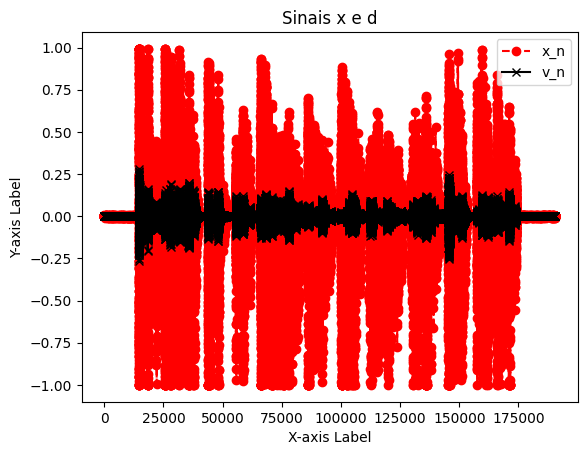


Audio original.



In [10]:
# importou o arquivo de audio
file_path = "locutor.wav"
x, fs = sf.read(file_path)

# importou a resposta ao pulso unitário
with open('ri.pkl', 'rb') as f:
    ri = pickle.load(f)
ri = ri.reshape(-1,1)
# resposta do sinal de entrada x ao filtro de pulso unitario
s = lfilter(ri.squeeze(), 1, x, axis=0)
s = s.reshape(-1,1)

# Na numero de amostras igual ao tamanho do vetor x
Na = x.shape[0]

# desvio padrao do ruido sigma_v = 0.0001
sigma_v = 0.0001

# s_awgn sinal de ruido
v_n = np.random.rand(Na)*sigma_v
v_n = v_n.reshape(-1,1)

# Sinal desejado
d_n = s + v_n

plt.plot( x, color='red', linestyle='--', marker='o', label='x_n')
plt.plot( d_n, color='black', linestyle='-', marker='x', label='v_n')

plt.xlabel("X-axis Label")
plt.ylabel("Y-axis Label")
plt.title("Sinais x e d")
plt.legend()
plt.show() # Displays the plot


# ouvir o audio original
print("\nAudio original.\n")
# A função espera um array CxN em que C é o número de canais e N o número de amostras
Audio(s.T, rate=fs)

# ouvir o audio com eco
#print("\nAudio com eco.\n")
# A função espera um array CxN em que C é o número de canais e N o número de amostras
#Audio(d_n.T, rate=fs)

# Exercício 2

Escreva uma função para implementar o algoritmo NLMS com as seguintes entradas e saídas:
```python

def nlms(x, d, M, Nit, etatil, delta):
    """
    Algoritmo NLMS

    Entradas
    x : vetor coluna com o sinal de entrada        
    d : vetor coluna com o sinal desejado        
    M : número de coeficientes do filtro
    Nit : número de iterações a simular (comprimento do sinal de entrada)
    etatil : passo de adaptação        
    delta : fator de regularizaçãofloat        

    Saídas:
    W : matriz (N+1, M) contendo, em cada linha, os coeficientes do filtro para
        uma determinada iteração        
    e : vetor coluna com o sinal de erro
    y : vetor coluna com o sinal de saída        
    """

    # código

    return W, e, y    

```

Em seguida, aplique o algoritmo NLMS com $\tilde{\eta}=0,1$, $\delta=10^{-5}$ e
$M=256$. Ouça os sinais $e(n)$ e $d(n)$. Note que a função `Audio` normaliza o volume do áudio e para desabilitar a normalização, pode ser usado o argumento `normalize=False`. Por fim, trace a curva ERLE para este caso usando a função `erle` fornecida. Considere que são usados blocos de `Nw=1024` amostras dos sinais $e(n)$ e $d(n)$ para estimar cada ponto da curva de ERLE.

In [11]:
def erle(d, e, Nw, fs):
    """
    Function to calculate the Echo Return Loss Enhancement (ERLE)
    after the echo canceller.

    Parameters:
    d : array_like
        Echo signal (desired signal)
    e : array_like
        Residual echo signal (adaptive filter error)
    Nw : int
        Number of samples in the window for echo estimation over time
    fs : int or float
        Sampling frequency

    Returns:
    ERLEdB : ndarray
        ERLE estimate in dB
    """

    N = len(d)
    Nb = N // Nw
    ERLEx = np.zeros(Nb)
    Ta = 1 / fs
    EPS = np.finfo(float).eps

    for i in range(Nb):
        l = slice(Nw * i, Nw * (i + 1))
        ERLEx[i] = np.mean(d[l]**2) / np.mean((e[l] + EPS)**2)

    ERLEdB = 10 * np.log10(ERLEx)

    # Plotting
    t = np.linspace(0, (N-1) * Ta, Nb)
    plt.plot(t, ERLEdB)
    plt.grid(True)
    plt.ylabel('ERLE (dB)')
    plt.xlabel('Time (s)')

    # Plotting d normalized and scaled to fit on the same plot
    td = np.linspace(t[0], t[-1], len(d))
    plt.plot(td, 10 * d / np.max(np.abs(d)) - 11)
    plt.plot([td[0], td[-1]], [-0.5, -0.5], 'k', linewidth=1)

    # Setting y-ticks and axis limits
    plt.yticks(np.arange(0, np.ceil(np.max(ERLEdB)) + 10, 10))
    plt.ylim([-21, np.ceil(np.max(ERLEdB))])
    plt.show()

    return ERLEdB

## Resolução

In [11]:
def nlms(x, d, M, Nit, etatil, delta):
    """
    Algoritmo NLMS

    Entradas
    x : vetor coluna com o sinal de entrada
    d : vetor coluna com o sinal desejado
    M : número de coeficientes do filtro
    Nit : número de iterações a simular (comprimento do sinal de entrada)
    etatil : passo de adaptação
    delta : fator de regularizaçãofloat

    Saídas:
    W : matriz (N+1, M) contendo, em cada linha, os coeficientes do filtro para
        uma determinada iteração
    e : vetor coluna com o sinal de erro
    y : vetor coluna com o sinal de saída
    """

    # código

    # Inicializacao das saidas
    # Coeficientes
    W = np.zeros((Nit+1, M))

    # erro
    e = np.zeros((Nit, 1))

    # saida
    y = np.zeros((Nit, 1))

    for n in range(M, Nit):
        # vetor de entrada com M amostras (janela)
        x_n = x[n:n-M:-1] if n-M >= 0 else np.flip(x[:n+1])
        x_n = np.pad(x_n, (0, M - len(x_n)))  # completa com zeros se necessário
        x_n = x_n.reshape(M, 1)

        # saída do filtro
        y[n] = np.dot(W[n, :], x_n)

        # erro
        e[n] = d[n] - y[n]

        # atualização dos coeficientes (NLMS)
        norm_factor = delta + np.dot(x_n.T, x_n)
        W[n+1, :] = W[n, :] + (etatil / norm_factor) * e[n] * x_n.T

    return W, e, y

# Exercício 3

*Double Talk*. Suponha agora que em vez de ruído, $v(n)$ seja um outro sinal
de voz [`eng.wav`](https://github.com/psi5892/exercicios_aula_publico/raw/refs/heads/main/eng.wav) não correlacionado com $x(n)$. Utilize então o
algoritmo NLMS com $\tilde{\eta}=0,5$, $\delta=10^{-5}$ e $M=256$,  para cancelar o eco do sinal de voz `locutor.wav` presente no sinal $d(n)$. Ouça os sinais $e(n)$ e $d(n)$. Explique os resultados obtidos.

## Resolução